# Predicting Sleep Disorders Using Health and Lifestyle Metrics

**Course:** STAT 301  
**Date:** April 1, 2025  
**Group Members:** Linda Chu, Mohammed Fouzan Hashmi, Tarun Narayan

## (2) Introduction

### Background Information

_TODO_

### Question of Interest
Can we predict whether an individual has a sleep disorder based on the available relevant categories in the dataset?

## (3) Methods and Results

### a.) Data
The Sleep Health and Lifestyle Dataset contains 400 observations and 13 variables, providing insights into sleep patterns, lifestyle factors, and cardiovascular health. 
The dataset includes numerical and categorical variables. (modified to include all variables in the dataset based on feedback from Assignment 1).
Column removed: Person ID.
Reason: This is a unique identifier for each individual and does not provide any meaningful information for prediction or analysis.

**Source:** The data source is artificial (i.e., the author of the dataset created synthetic data for illustrative purposes).  
**Citation:** Dataset retrieved from: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data.

Table of variable name, type and description:

| Variable                  | Type        | Description                                   |
|---------------------------|------------|-----------------------------------------------|
| **Person ID**             | Categorical | Unique identifier for each individual         |
| **Gender**                | Categorical | Male/Female                                  |
| **Age**                   | Numerical   | Age in years                                 |
| **Occupation**            | Categorical | Type of profession                          |
| **Sleep Duration**        | Numerical   | Hours of sleep per day                      |
| **Quality of Sleep**      | Numerical   | Self-reported sleep quality (1-10)          |
| **Physical Activity Level** | Numerical | Minutes of physical activity per day       |
| **Stress Level**          | Numerical   | Self-reported stress level (1-10)           |
| **BMI Category**          | Categorical | Underweight, Normal, Overweight             |
| **Blood Pressure**        | Numerical   | Systolic/Diastolic measurement              |
| **Heart Rate**            | Numerical   | Beats per minute (bpm)                      |
| **Daily Steps**           | Numerical   | Number of steps per day                     |
| **Sleep Disorder**        | Categorical | None, Insomnia, Sleep Apnea                 |


### b) Exploratory Data Analysis

In [50]:
library(tidyverse)
library(caret)
library(pROC)
library(boot)
library(dplyr)

In [60]:
# Load the dataset
sleep_data <- read_csv("https://raw.githubusercontent.com/Tarun-Narayan/STAT301-GroupProject/refs/heads/main/sleep_health.csv", show_col_types = FALSE)

# Clean and wrangle data into a tidy format
sleep_data <- sleep_data %>%
  drop_na() %>%
  distinct()

# Renaming column names to remove space
sleep_data <- sleep_data %>%
  rename(ID = `Person ID`,
         Sleep_Duration = `Sleep Duration`, 
         Sleep_Quality = `Quality of Sleep`,
         Phys_Level = `Physical Activity Level`,
         Stress_Level = `Stress Level`, 
         Sleep_Disorder = `Sleep Disorder`,
         BMI_Category = `BMI Category`,
         Blood_Pressure = `Blood Pressure`,
         Heart_Rate = `Heart Rate`,
         Daily_Steps = `Daily Steps`)

#Combining 'Normal Weight' and 'Normal'
sleep_data <- sleep_data %>%
  mutate(BMI_Category = ifelse(BMI_Category == "Normal Weight", "Normal", BMI_Category)) #%>%
  #mutate(Occupation = ifelse(Occupation == "Sales Representative", "Salesperson", Occupation))

In [61]:
# Splitting Blood pressure into Systolic BP and Diastolic BP
sleep_data <- sleep_data %>%
  separate(Blood_Pressure, into = c("Systolic_BP", "Diastolic_BP"), sep = "/", convert = TRUE) 

# Modify Sleep_Disorder and BMI_Cateogry to factor
sleep_data <- sleep_data %>% 
  mutate(Sleep_Disorder = ifelse(Sleep_Disorder == "None", 0, 1), 
         Sleep_Disorder = as.factor(Sleep_Disorder),
         BMI_Category = as.factor(BMI_Category))

glimpse(sleep_data)

Rows: 374
Columns: 14
$ ID             <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ Gender         <chr> "Male", "Male", "Male", "Male", "Male", "Male", "Male",…
$ Age            <dbl> 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29,…
$ Occupation     <chr> "Software Engineer", "Doctor", "Doctor", "Sales Represe…
$ Sleep_Duration <dbl> 6.1, 6.2, 6.2, 5.9, 5.9, 5.9, 6.3, 7.8, 7.8, 7.8, 6.1, …
$ Sleep_Quality  <dbl> 6, 6, 6, 4, 4, 4, 6, 7, 7, 7, 6, 7, 6, 6, 6, 6, 5, 6, 5…
$ Phys_Level     <dbl> 42, 60, 60, 30, 30, 30, 40, 75, 75, 75, 30, 75, 30, 30,…
$ Stress_Level   <dbl> 6, 8, 8, 8, 8, 8, 7, 6, 6, 6, 8, 6, 8, 8, 8, 8, 7, 8, 7…
$ BMI_Category   <fct> Overweight, Normal, Normal, Obese, Obese, Obese, Obese,…
$ Systolic_BP    <int> 126, 125, 125, 140, 140, 140, 140, 120, 120, 120, 120, …
$ Diastolic_BP   <int> 83, 80, 80, 90, 90, 90, 90, 80, 80, 80, 80, 80, 80, 80,…
$ Heart_Rate     <dbl> 77, 75, 75, 85, 85, 85, 82, 70, 70, 70, 70, 70, 70, 70,…
$ Daily_Steps    <

In [63]:
# Summary tables to view counts per category
count(sleep_data, Occupation)

# There is only 1 Manager.

count(sleep_data, Sleep_Disorder)

# The two groups are relatively balanced.

count(sleep_data, BMI_Category)

# The groups are unbalanced; few are in the 'Obese' category.

Occupation,n
<chr>,<int>
Accountant,37
Doctor,71
Engineer,63
Lawyer,47
Manager,1
Nurse,73
Sales Representative,2
Salesperson,32
Scientist,4


Sleep_Disorder,n
<fct>,<int>
0,219
1,155


BMI_Category,n
<fct>,<int>
Normal,216
Obese,10
Overweight,148


### c) Methods: Plan

We will use binary logistic regression implemented with glm() to predict whether an individual has a sleep disorder (Yes/No = 1/0). 

This method is appropriate because: The response variable (Sleep_Disorder, which is a categorical variable with 3 categories) can be transformed into a binomial variable (i.e., has Sleep disorder/ doesn't have sleep disoder).
Logistic regression models the probability of an outcome using a logistic function.
It allows us to analyze how the response variables influence the likelihood of having a sleep disorder.

### Assumptions:
1) Binary Response: The response variable must have only two categories (Yes/No).
2) Independence: Observations must be independent of one another.
3) Variance Structure: The variance follows a binomial distribution, highest when 
p=0.5.
4) Linearity in Log-Odds: The log of the odds should have a linear relationship with the predictors.

### Potential Limitations: 
1) Linearity Assumption: If the relationship between predictors and log-odds is non-linear, transformations may be needed.
2) Class Imbalance: Unequal distribution of 1/0 cases may affect predictive performance.
3) Unobserved Variables: Other important factors (e.g., genetics, caffeine intake) which may be indicators for sleep disorders are not included in this model.

In [65]:
set.seed(123) 

# Split into train (70%) and test (30%) sets
sleep_train <- sleep_data %>% slice_sample(prop = 0.7)
sleep_test <- sleep_data %>% anti_join(sleep_train, by = "ID")

# Remove ID column
sleep_train <- sleep_train %>% select(-`ID`)
sleep_test <- sleep_test %>% select(-`ID`)

head(sleep_train)
nrow(sleep_train)

# Fit logistic regression model using glm()
logit_model <- glm(Sleep_Disorder ~ ., data = sleep_train, family = binomial)

summary(logit_model)

Gender,Age,Occupation,Sleep_Duration,Sleep_Quality,Phys_Level,Stress_Level,BMI_Category,Systolic_BP,Diastolic_BP,Heart_Rate,Daily_Steps,Sleep_Disorder
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<dbl>,<dbl>,<fct>
Male,42,Lawyer,7.8,8,90,5,Normal,130,85,70,8000,0
Male,29,Doctor,6.0,6,30,8,Normal,120,80,70,8000,0
Male,43,Salesperson,6.5,6,45,7,Overweight,130,85,72,6000,1
Female,51,Nurse,6.1,6,90,8,Overweight,140,95,75,10000,1
Female,37,Accountant,7.2,8,60,4,Normal,115,75,68,7000,0
Female,51,Engineer,8.5,9,30,3,Normal,125,80,65,5000,0


[1] 261

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Sleep_Disorder ~ ., family = binomial, data = sleep_train)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)                    -7.004e+03  8.850e+05  -0.008   0.9937  
GenderMale                     -9.985e+01  1.236e+04  -0.008   0.9936  
Age                            -7.639e-01  4.431e-01  -1.724   0.0847 .
OccupationDoctor               -3.289e+02  4.257e+04  -0.008   0.9938  
OccupationEngineer             -3.156e+02  5.405e+04  -0.006   0.9953  
OccupationLawyer               -3.180e+02  5.405e+04  -0.006   0.9953  
OccupationManager              -1.786e+02  2.196e+05  -0.001   0.9994  
OccupationNurse                -3.449e+02  4.173e+04  -0.008   0.9934  
OccupationSales Representative -3.543e+02  1.917e+05  -0.002   0.9985  
OccupationSalesperson           2.687e+01  2.146e+04   0.001   0.9990  
OccupationScientist            -3.523e+02  4.745e+07   0.000   1.0000  
OccupationSoftware Engineer    -1.965e+02

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 57  5
         1  6 45
                                          
               Accuracy : 0.9027          
                 95% CI : (0.8325, 0.9504)
    No Information Rate : 0.5575          
    P-Value [Acc > NIR] : 1.121e-15       
                                          
                  Kappa : 0.8031          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9000          
            Specificity : 0.9048          
         Pos Pred Value : 0.8824          
         Neg Pred Value : 0.9194          
             Prevalence : 0.4425          
         Detection Rate : 0.3982          
   Detection Prevalence : 0.4513          
      Balanced Accuracy : 0.9024          
                                          
       'Positive' Class : 1               
                                    

Setting levels: control = 0, case = 1

Setting direction: controls < cases



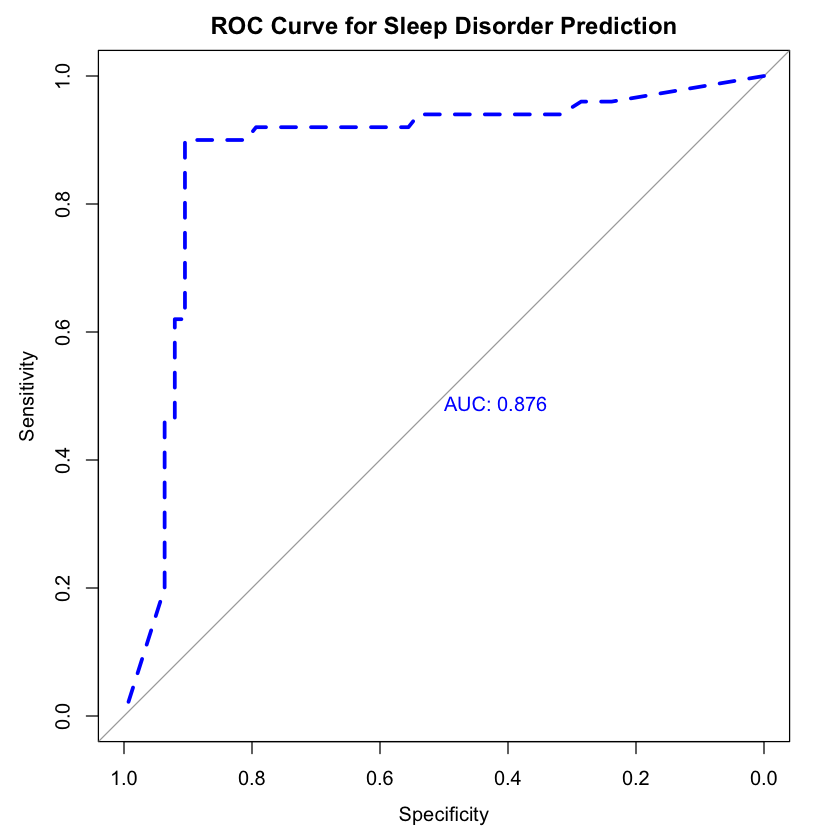

In [66]:
# Predict on test set
sleep_test$Predicted_Prob <- predict(logit_model, newdata = sleep_test, type = "response")
sleep_test$Predicted_Disorder <- ifelse(sleep_test$Predicted_Prob > 0.5, "1", "0")

# Confusion matrix
conf_matrix <- confusionMatrix(
   data = as.factor(sleep_test$Predicted_Disorder),
   reference = as.factor(sleep_test$Sleep_Disorder),
   positive = "1"
)
print(conf_matrix)

# ROC Curve
ROC_logit <- roc(
  response = as.numeric(sleep_test$Sleep_Disorder) - 1,  
  predictor = sleep_test$Predicted_Prob
)

# Plot ROC Curve
plot(ROC_logit,
     print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "ROC Curve for Sleep Disorder Prediction")

## (4) Discussion

The ROC curve shows that the logistic regression model performs well in predicting sleep disorders, with an AUC of 0.876, indicating strong discriminatory power. The model effectively distinguishes between individuals with and without sleep disorders, as seen from the steep rise in sensitivity. This confirms that these factors (i.e., Age, BMI, Sleep duration, Blood Pressure, etc.) play a significant role in sleep disorder classification. Further refinement, such as incorporating additional predictors or handling potential class imbalances, could enhance model performance.